In [1]:
import subprocess
from getpass import getpass

password = getpass()
cmd = ["openssl", "enc", "-d", "-aes-256-cbc", "-in", "openai-key.enc", "-pass", f"pass:{password}"]
key = subprocess.run(cmd, capture_output=True, text=True).stdout.strip("\n")

 ········


In [2]:
from openai import OpenAI
client = OpenAI(api_key=key)

## Demo

In [19]:
# Right image description: Three sad people wearing swimming caps standing behind a happy person with no hair. Everyone is in a swimming pool.
response = client.images.generate(
    model="dall-e-3",
    prompt='''Draw only using stick figures (black silhouettes against a white background):
    Three sad people wearing swimming caps standing behind a happy person with no hair. Everyone is in a swimming pool.
    ''',
    size="1024x1024",
    quality="standard",
    n=1,
    response_format="b64_json",
)

#print(response)

In [21]:
import base64
with open("down.png", "wb") as f:
    f.write(base64.b64decode(response.data[0].b64_json))

In [20]:
print(response.data[0].revised_prompt)

Illustrate a simple sketch in the style of a webcomic. The scene includes four Caucasian males. Three of them are standing in a group, each with a head full of hair and expressing happiness. In front of them, there is another man who is bald and portrays a sad expression.


## Run

In [62]:
from typing import Tuple
from PIL import Image
import io

def png_to_img(png_bytes: bytes) -> Image.Image:
    with io.BytesIO(png_bytes) as png_buffer:
        image = Image.open(png_buffer)
        image = image.convert("RGB")
    return image

def generate(prompt: str) -> Tuple[Image.Image,str]:
    
    system_prompt = "Draw only using stick figures (black silhouettes against a white background):\n"
    final_prompt = system_prompt+prompt
    
    response = client.images.generate(
        model="dall-e-3",
        prompt=final_prompt,
        size="1024x1024",
        quality="standard",
        n=1,
        response_format="b64_json")

    png_bytes = base64.b64decode(response.data[0].b64_json)
    image = png_to_img(png_bytes)
    
    return image,response.data[0].revised_prompt

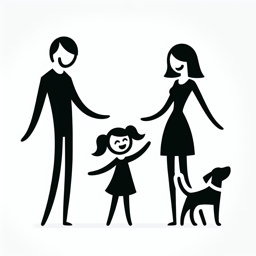

In [63]:
display(generate("happy family")[0].resize((256,256)))

In [90]:
import os, csv, json
from tqdm import tqdm

outpath = "outputs/dalle3/"
#side = "yes"
side = "but"

In [91]:
file_path = "annotations.csv"
annotations = {}

with open(file_path, 'r', encoding='utf-8') as file:
    reader = csv.DictReader(file)
    annotations = {row['filename']: {"yes": row['left_image'], "but": row['right_image']} for row in reader}
assert len(annotations)==283

In [95]:
done = [x.split(f"_{side.upper()}")[0]+".jpg" for x in os.listdir(os.path.join(outpath,side)) if os.path.splitext(x)[1]==".jpg"]
if len(done) == 0:
    print("[WARN] No previously generated files found")
else:
    print(f"[INFO] Found {len(done)} previously generated files, skipping")
    
try:
    with open(os.path.join(outpath,f"revised_prompts_{side}.json"), "r") as f:
        revised_prompts = json.load(f)
except FileNotFoundError:
    print("[WARN] No revised prompts found")
    revised_prompts = {}

if set(done)!=set(revised_prompts.keys()):
    print(f"[WARN] Mismatch in prompts: #images={len(done)}, #prompts: {len(revised_prompts)}")

to_do = {k:v for k,v in annotations.items() if k not in done}
print(f"Doing {len(to_do)} files")

for filename,descriptions in tqdm(to_do.items()):
    try:
        image,revised_prompt = generate(descriptions[side])
    except Exception as e:
        print(f"Could not do {filename}, {side}: {descriptions[side]}, due to error: {e}")
        continue

    outfile = f"{os.path.splitext(filename)[0]}_{side.upper()}_gen_1.jpg"
    
    image.save(os.path.join(outpath,side,outfile), "JPEG")

    revised_prompts[filename] = revised_prompt
    with open(os.path.join(outpath,f"revised_prompts_{side}.json"), "w") as f:
        json.dump(revised_prompts, f, indent=4)
    

[INFO] Found 283 previously generated files, skipping
Doing 0 files


0it [00:00, ?it/s]
